In [35]:
import nilearn
import popeye
import os
import cortex

In [2]:
picklepath='/Volumes/BAHAMUT/OUTPUT/FULL/outputs'

In [3]:
import dill
def load(filename):
	input_file = open(filename, 'rb')
	obj = dill.load(input_file)
	return obj

Get a list of the outputs that were generated from the model fitting.

In [4]:
def findgiftis(FOLDER,ext):
    
    # Function goal: return nifti files within a directory
    
    # Detail: could be used for a file with any extension...
    
    #Inputs
    
    # FOLDER (directory to search)
    # ext (the suffix (.nii or .nii.gz))
    
    def fprintf(stream, format_spec, *args):
        stream.write(format_spec % args)
    import os
    import sys
    niftilist=list()
    for file in os.listdir(FOLDER):
        if file.endswith(ext) and not file.startswith('.'):
            niftilist.append(FOLDER+"/"+file)
    fprintf(sys.stdout, "Found %d gifti files \n", len(niftilist))
    return(sorted(niftilist))

mylist=findgiftis(picklepath,'.pkl')

Found 200 gifti files 


I split each hemisphere into 100 jobs (each with around 1300 vertices fit). Thus, each pickle is a list of lists -wherein each list contains a popeye model.

Split these into left and right

In [5]:
mylistL=[res for res in mylist if "l." in(res)]
mylistR=[res for res in mylist if "r." in(res)]

In [6]:
def p2panda(file):
    import pandas as pd
    fits=load(file)
    ROI=os.path.splitext(os.path.split(file)[1])[0]
    csvframe=list()
    i=0
    for fit in fits:
        df=pd.DataFrame(fit.estimate)
        df=df.T
        df.columns=['X','Y','S','h','b','u']
        df['R2'] = fit.rsquared
        df['ROI'] = ROI
        df['idx'] = fit.voxel_index[-1]
        csvframe.append(df)
        i=i+1
    frame=pd.concat(csvframe)
    return frame

In [7]:
def p2lframe(file,hem):
    fits=load(file)
    csvframe=list()
    for fit in fits:
        longf=pd.DataFrame(fit.prediction)
        longf.columns=['pred']
        longf['data']=fit.data
        longf['X'] =np.repeat(fit.estimate[0],longf.shape[0])
        longf['Y'] =np.repeat(fit.estimate[1],longf.shape[0])
        longf['S'] =np.repeat(fit.estimate[2],longf.shape[0])
        longf['r2'] =np.repeat(fit.rsquared,longf.shape[0])
        longf['idx']= np.repeat(fit.voxel_index[-1],longf.shape[0])
        longf['hem']= np.repeat(hem,longf.shape[0])
        csvframe.append(longf)
    frame=pd.concat(csvframe)
    return frame

In [8]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np

lframe=list()
lframe=Parallel(n_jobs=5,verbose=9)(delayed(p2lframe)(item,1)  for item in mylistL)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   35.5s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   53.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.9min finished


In [9]:
rframe=list()
rframe=Parallel(n_jobs=5,verbose=9)(delayed(p2lframe)(item,2)  for item in mylistR)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   24.6s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   39.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.7min finished


In [10]:
longframe=pd.concat([pd.concat(lframe),pd.concat(rframe)])

In [11]:
dump_path='/Volumes/BAHAMUT/OUTPUT/FULL'

In [12]:
longframe.to_csv(os.path.join(dump_path,'lframe.csv'))

Load these in and append them to one another. 

In [12]:
import popeye
import dill
def load(filename):
	input_file = open(filename, 'rb')
	obj = dill.load(input_file)
	return obj

In [13]:
frameL=list()
#for item in mylistL:
#    frameL.append(p2panda(item))
    
frameL=Parallel(n_jobs=5,verbose=9)(delayed(p2panda)(item)  for item in mylistL)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   40.2s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   56.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.0min finished


In [14]:
frameR=list()
#for item in mylistR:
#    frameR.append(p2panda(item))

frameR=Parallel(n_jobs=5,verbose=9)(delayed(p2panda)(item)  for item in mylistR)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   32.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   51.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.3min finished


In [15]:
import pandas as pd
bigframeL=pd.concat(frameL)
bigframeR=pd.concat(frameR)

In [16]:
bigframe=pd.concat([bigframeL,bigframeR])

In [20]:
bigframe.head()

,X,Y,S,h,b,u,R2,ROI,idx
0,-4.030473,2.704765,10.000000,-2.516819,0.000623,0.000628,0.276955,000l,0
0,0.179200,-0.607032,2.472724,-1.976380,0.001142,0.001157,0.564186,000l,1
0,-30.473289,0.822103,0.564935,-2.989550,0.000063,-0.000470,0.040571,000l,2
0,5.843050,-50.000000,1.174882,2.994956,0.000122,-0.000432,0.019436,000l,3
0,-15.738522,23.369613,10.000000,-0.516279,0.000857,0.000155,0.449776,000l,4


Now create some empty vectors for each of the parameters we want to create.

In [17]:
import numpy as np
R2arrayL=np.zeros(163842,dtype=np.float64)
sarrayL=np.zeros(163842,dtype=np.float64)
eccarrayL=np.zeros(163842,dtype=np.float64)
angarrayL=np.zeros(163842,dtype=np.float64)
xarrayL=np.zeros(163842,dtype=np.float64)
yarrayL=np.zeros(163842,dtype=np.float64)
indL=np.zeros(163842,dtype=np.float64)

R2arrayR=np.zeros(163842,dtype=np.float64)
sarrayR=np.zeros(163842,dtype=np.float64)
eccarrayR=np.zeros(163842,dtype=np.float64)
angarrayR=np.zeros(163842,dtype=np.float64)
xarrayR=np.zeros(163842,dtype=np.float64)
yarrayR=np.zeros(163842,dtype=np.float64)
indR=np.zeros(163842,dtype=np.float64)

This formula will define polar angle in such a way that 0 is the upper vertical meridian and this increases clockwise. 

In [18]:
for i in range(bigframeL.shape[0]):
    val=bigframeL['idx'].iloc[i]
    R2arrayL[val]=bigframeL['R2'].iloc[i]*100
    sarrayL[val]=bigframeL['S'].iloc[i]
    eccarrayL[val]=np.sqrt(bigframeL['X'].iloc[i]**2+bigframeL['Y'].iloc[i]**2)
    angarrayL[val]=np.rad2deg(np.mod(np.arctan2(bigframeL['X'].iloc[i],bigframeL['Y'].iloc[i]),2*np.pi))
    xarrayL[val]=bigframeL['X'].iloc[i]
    yarrayL[val]=bigframeL['Y'].iloc[i]
    indL[val]=bigframeL['idx'].iloc[i]

In [19]:
for i in range(bigframeR.shape[0]):
    val=bigframeR['idx'].iloc[i]
    R2arrayR[val]=bigframeR['R2'].iloc[i]*100
    sarrayR[val]=bigframeR['S'].iloc[i]
    eccarrayR[val]=np.sqrt(bigframeR['X'].iloc[i]**2+bigframeR['Y'].iloc[i]**2)
    angarrayR[val]=np.rad2deg(np.mod(np.arctan2(bigframeR['X'].iloc[i],bigframeR['Y'].iloc[i]),2*np.pi))
    xarrayR[val]=bigframeR['X'].iloc[i]
    yarrayR[val]=bigframeR['Y'].iloc[i]
    indR[val]=bigframeR['idx'].iloc[i]

In [20]:
R2arrayL=np.nan_to_num(R2arrayL.reshape([1, 163842]),0)
sarrayL=np.nan_to_num(sarrayL.reshape([1, 163842]),0)
eccarrayL=np.nan_to_num(eccarrayL.reshape([1, 163842]),0)
angarrayL=np.nan_to_num(angarrayL.reshape([1, 163842]),0)

xarrayL=np.nan_to_num(xarrayL.reshape([1, 163842]),0)
yarrayL=np.nan_to_num(yarrayL.reshape([1, 163842]),0)
indL=np.nan_to_num(indL.reshape([1, 163842]),0)

In [21]:
R2arrayR=np.nan_to_num(R2arrayR.reshape([1, 163842]),0)
sarrayR=np.nan_to_num(sarrayR.reshape([1, 163842]),0)
eccarrayR=np.nan_to_num(eccarrayR.reshape([1, 163842]),0)
angarrayR=np.nan_to_num(angarrayR.reshape([1, 163842]),0)

xarrayR=np.nan_to_num(xarrayR.reshape([1, 163842]),0)
yarrayR=np.nan_to_num(yarrayR.reshape([1, 163842]),0)
indR=np.nan_to_num(indR.reshape([1, 163842]),0)


In [22]:
neurophy_path='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/prfs' 

# Export these into a curv file so that the retinotopic maps can be inferred


The instructions are as follows:

Polar angle must be in degrees of rotation clockwise starting from the upper vertical meridian. This means that the upper vertical meridian is 0°, the right horizontal meridian is 90°, the left horizontal meridian is -90°, and the lower vertical meridian is ±180°.

Eccentricity must be in degrees of visual angle from the fovea. ✅ 

Sigma/pRF size must be degrees of the visual field. ✅ 

Variance explained must be a fraction between v such that 0 ≤ v ≤ 1. ✅ (just divide by 100).


**To be clear, both the left and right hemispheres' angle files should specify the polar angle in positive degrees; for the right hemisphere, positive refers to the left visual hemi-field; for the left hemisphere, positive values refer to the right visual hemi-field. In both cases, 0 represents the upper vertical meridian and 180 represents the lower vertical meridian** 

This isn't totally clear... The thing is, I checked the example data and these seem to contain negative values (a smaller number than the positive values). This implies that the ipsilateral space is coded as negative. 

And so this seems to imply that we need to ensure that the left facing elements of the left hemisphere (greater than 180) need to be negative.

However, this seems an odd way of doing things, so I'm going to preserve my original format and store this in a new variable.

In [23]:
angarrayL2=np.copy(angarrayL)
angarrayR2=np.copy(angarrayR)

In [24]:
angarrayL2[angarrayL2>180]=angarrayL2[angarrayL2>180]-360

And for the right hemisphere, the elements to the right need to be negative.

In [25]:
angarrayR2[angarrayR2<180]=np.negative(angarrayR2[angarrayR2<180])

In [26]:
angarrayR2[angarrayR2>180]=360-angarrayR2[angarrayR2>180]

In [27]:
tangarray=np.absolute(np.concatenate([angarrayL2,angarrayR2],axis=1))

Output these to _curve files. The script that was execute on these is called /neuropythy/nprunner.sh

In [25]:
import nibabel

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_vexpl_curv'),np.squeeze(R2arrayL/100))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_vexpl_curv'),np.squeeze(R2arrayR/100))

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_sigma_curv'),np.squeeze(sarrayL))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_sigma_curv'),np.squeeze(sarrayR))

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_eccen_curv'),np.squeeze(eccarrayL))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_eccen_curv'),np.squeeze(eccarrayR))

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_ang_curv'),np.squeeze(angarrayL2))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_ang_curv'),np.squeeze(angarrayR2))

For cortex plotting, we can put all this into one long array.

In [28]:
R2array=np.concatenate([R2arrayL,R2arrayR],axis=1)
sarray=np.concatenate([sarrayL,sarrayR],axis=1)
eccarray=np.concatenate([eccarrayL,eccarrayR],axis=1)
angarray=np.concatenate([angarrayL,angarrayR],axis=1)

xarray=np.concatenate([xarrayL,xarrayR],axis=1)
yarray=np.concatenate([yarrayL,yarrayR],axis=1)
indarray=np.concatenate([indL,indR],axis=1)

In [29]:
R2array[R2array==0]=np.nan
sarray[sarray==0]=np.nan
eccarray[eccarray==0]=np.nan
angarray[angarray==0]=np.nan


xarray[xarray==0]=np.nan
yarray[yarray==0]=np.nan
#indarray[indarray==0]=np.nan


Now take the output of neuropythy and assign this as a new vector. 

In [30]:
from nilearn import surface

inferredL='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_varea.curv'
inferredR='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_varea.curv'

iL = surface.load_surf_data(inferredL)
iR = surface.load_surf_data(inferredR)
iarray=np.concatenate([iL,iR],axis=0)

inferredLa='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_angle.curv'
inferredRa='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_angle.curv'

iLa = surface.load_surf_data(inferredLa)
iRa = surface.load_surf_data(inferredRa)
iangarray=np.concatenate([iLa,iRa],axis=0)

inferredLe='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_eccen.curv'
inferredRe='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_eccen.curv'

iLe = surface.load_surf_data(inferredLe)
iRe = surface.load_surf_data(inferredRe)
ieccarray=np.concatenate([iLe,iRe],axis=0)

inferredLs='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_sigma.curv'
inferredRs='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_sigma.curv'

iLs = surface.load_surf_data(inferredLs)
iRs = surface.load_surf_data(inferredRs)
isarray=np.concatenate([iLs,iRs],axis=0)




In [31]:
noisemod=surface.load_surf_data('/Volumes/BAHAMUT/OUTPUT/FULL/noisefit.curv')
noisemod=noisemod*100

In [32]:
import cortex as cx

The next few lines are commented out - but here I draw the appropriate boundaries according to the estimates given by neuropythy.

In [ ]:
#ROIlabs=['None','V1','V2','V3','hV4','VO1','VO2','LO1','LO2','TO1','TO2','V3b','V3a']

In [ ]:
#tempiarray=np.copy(iarray)
#def ROIMASK(region,tempiarray):
#    idx=ROIlabs.index(region)
#    tempiarray[tempiarray!=idx]=0
#    tempiarray[tempiarray==idx]=1
#    temparray=tempiarray
#    tempvert=cx.Vertex(temparray, subject='02',cmap='gist_ncar',description='Inferred atlas',threshold=1e-6)
#    cx.add_roi(tempvert,open_inkscape=True,name=region)

In [ ]:
# ROIMASK('V3a',tempiarray)

Bundle everything together for the webGL viewer

In [33]:
v1 = cx.Vertex(R2array, subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6)
v2 = cx.Vertex(sarray, subject='02',cmap='plasma',description='Sigma',threshold=1e-6,vmax=5)
v2i = cx.Vertex(isarray, subject='02',cmap='plasma',description='Inferred Sigma',threshold=1e-6,vmax=10)
v3 = cx.Vertex(eccarray, subject='02',cmap='plasma',description='Eccentrcity',vmax=8,threshold=1e-6)
v3i = cx.Vertex(ieccarray, subject='02',cmap='plasma',description='Inferred Eccentrcity',vmax=8,threshold=1e-6)
v4 = cx.Vertex(angarray, subject='02',cmap='plasma',description='Angle',threshold=1e-6)
v4i = cx.Vertex(iangarray, subject='02',cmap='plasma',description='Inferred Angle',threshold=1e-6)
va2 = cx.Vertex(tangarray, subject='02',cmap='plasma',description='Inferred Angle',threshold=1e-6)


v5 = cx.Vertex(xarray, subject='02',cmap='plasma',description='X position',threshold=1e-6)
v6 = cx.Vertex(yarray, subject='02',cmap='plasma',description='Y position',threshold=1e-6)
v7 = cx.Vertex(indarray, subject='02',cmap='plasma',description='index',threshold=1e-6)

v8=cx.Vertex(iarray, subject='02',cmap='gist_ncar',description='Inferred atlas',threshold=1e-6)
v9=cx.Vertex(noisemod, subject='02',cmap='plasma',description='Noise model fit',threshold=1e-6)


volumes = {
    'Variance explained': v1,
    'Sigma': v2,
    'Inferred Sigma': v2i,
    'Eccentricity': v3,
    'Inferred Eccentricity': v3i,
    'Polar angle': v4,
    'Inferred Polar angle': v4i,
    'Angle transformed': va2,
    'X position': v5,
    'Y position': v6,
    'index': v7,
    'Inferred Atlas': v8,
    'Noise Model fit': v9
    
    
}

In [34]:
cx.webgl.show(data=volumes,with_curvature=True,with_sulci=True,with_rois=True,recache=True)

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 9247


<JS: window.viewer>

Now plot some flatmaps of the parameters.

In [50]:
import matplotlib.pyplot as plt

flatmap_height = 2048
full_figsize = (24, 16)

full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)

In [54]:
def export_lightflatmap(dump_path,array,weightarray,param_name,vmin,vmax,vmin2,vmax2):
    
    flat_path=os.path.join(dump_path,'FLATMAPS')
    heavy=cx.Vertex(array, subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6,vmin=vmin, vmax=vmax)
    light=cx.Vertex2D(array,weightarray/100,subject='02', vmin=vmin, vmax=vmax,vmin2=vmin2,vmax2=vmax2,cmap='plasma_alpha')
    
    lightfig=cx.quickshow(light, with_rois=False, with_curvature=True,fig=full_fig, with_colorbar=False)
    lightfig.savefig(os.path.join(flat_path,param_name+'l_flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None)

In [55]:
def export_heavyflatmap(dump_path,array,param_name,vmin,vmax):
    
    flat_path=os.path.join(dump_path,'FLATMAPS')
    heavy=cx.Vertex(array, subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6,vmin=vmin, vmax=vmax)
    
    heavyfig=cx.quickshow(heavy, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)
    heavyfig.savefig(os.path.join(flat_path,param_name+'h_flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None)
    

In [65]:
def export_customflatmap(dump_path,array,weightarray,param_name,vmin,vmax,vmin2,vmax2):
    
    flat_path=os.path.join(dump_path,'FLATMAPS')
    heavy=cx.Vertex(array, subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6,vmin=vmin, vmax=vmax)
    light=cx.Vertex2D(array,weightarray/100,subject='02', vmin=vmin, vmax=vmax,vmin2=vmin2,vmax2=vmax2,cmap='plasma_alpha')
    
    lightfig=cx.quickshow(light, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=False)
    lightfig.savefig(os.path.join(flat_path,param_name+'custom_flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


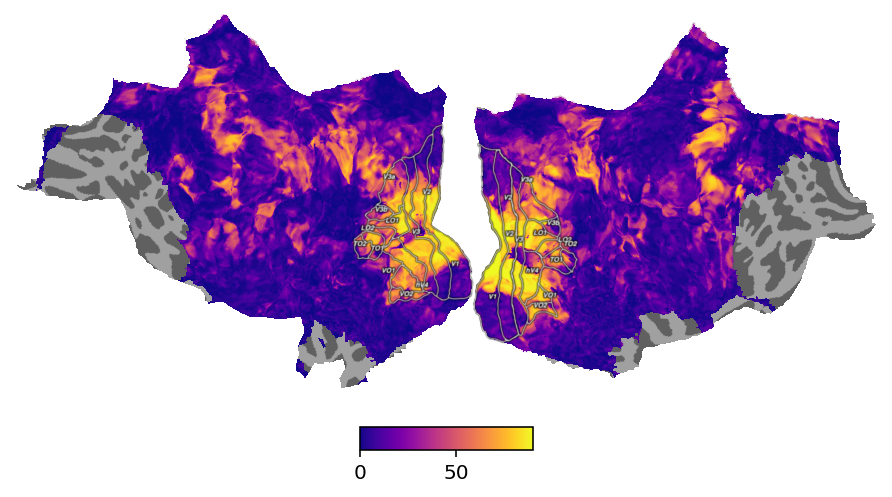

In [66]:
export_lightflatmap(dump_path,R2array,R2array,"Variance Explained",0,90,0.15,1)
export_customflatmap(dump_path,R2array,R2array,"Variance Explained",0,90,0.15,1)

export_heavyflatmap(dump_path,R2array,"Variance Explained",0,90)

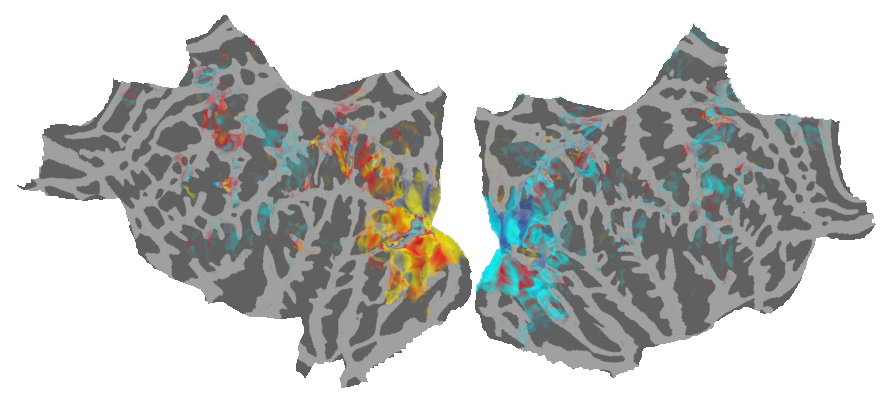

Stopping server


In [79]:
flat_path=os.path.join(dump_path,'FLATMAPS')

light=cx.Vertex2D(angarray,R2array/100,subject='02', vmin=0, vmax=360,vmin2=0.15,vmax2=1,cmap='Retinotopy_RYBCR_alpha')
    
lightfig=cx.quickshow(light, with_rois=False, with_curvature=True,fig=full_fig, with_colorbar=False)
lightfig.savefig(os.path.join(flat_path,'angcmap'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1)


Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


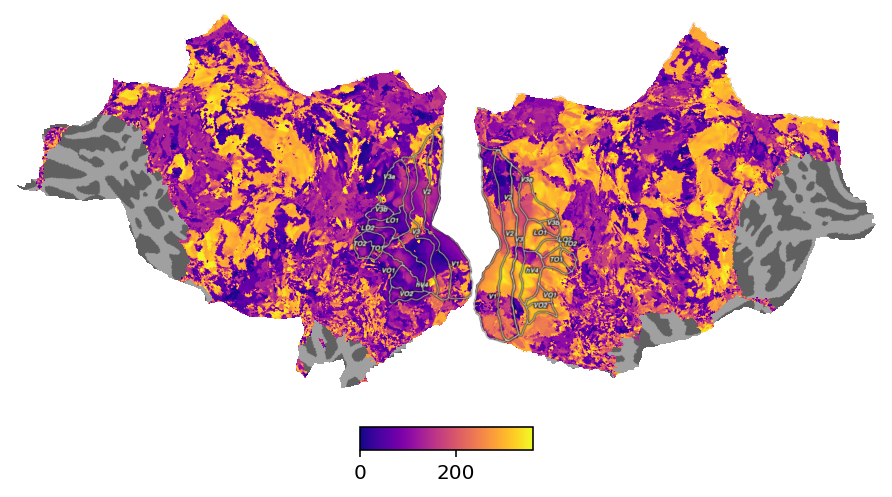

In [69]:
export_lightflatmap(dump_path,angarray,R2array,"Polar Angle",0,360,0.15,1)
export_customflatmap(dump_path,angarray,R2array,"Polar Angle",0,360,0.15,1)

export_heavyflatmap(dump_path,angarray,"Polar Angle",0,360)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


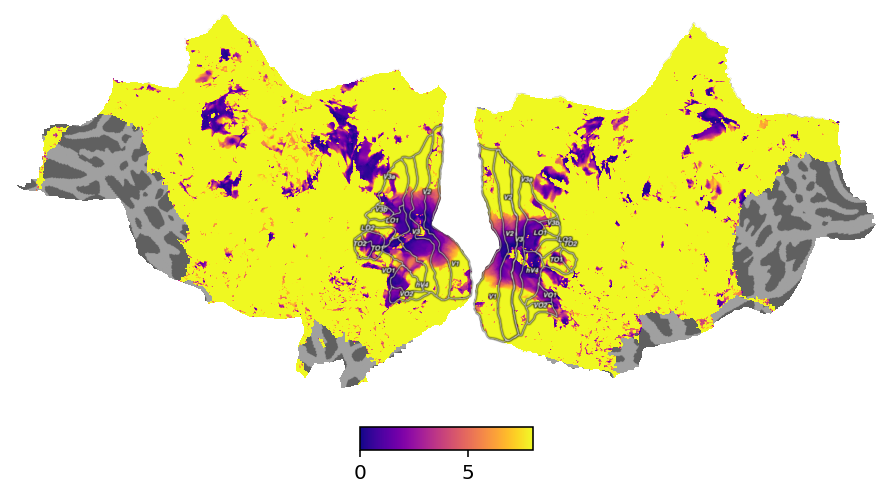

In [67]:
export_lightflatmap(dump_path,eccarray,R2array,"Eccentricity",0,8,0.15,1)
export_customflatmap(dump_path,eccarray,R2array,"Eccentricity",0,8,0.15,1)
export_heavyflatmap(dump_path,eccarray,"Eccentricity",0,8)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


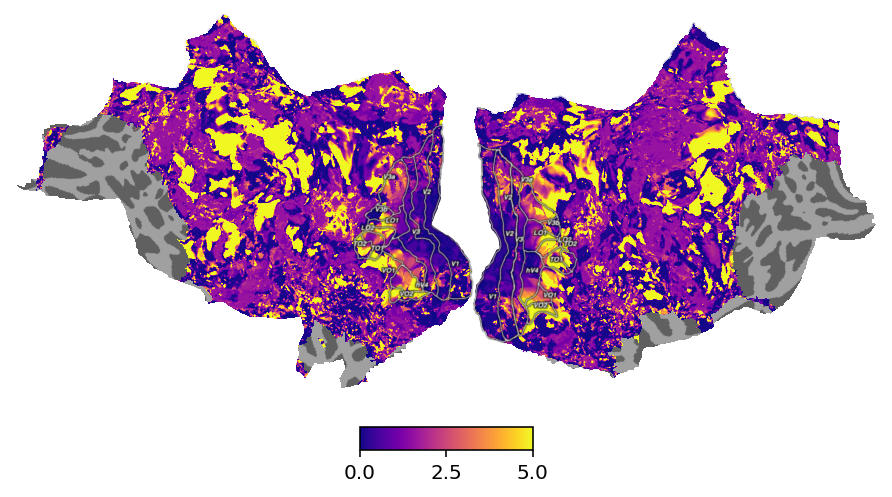

In [68]:
export_lightflatmap(dump_path,sarray,R2array,"Size",0,5,0.15,1)
export_customflatmap(dump_path,sarray,R2array,"Size",0,5,0.15,1)
export_heavyflatmap(dump_path,sarray,"Size",0,5)

Bundle everything into a dataframe so we can do some R plotting.

In [53]:
df=pd.DataFrame(np.transpose(R2array))
df.columns=['R2']
df['sigma']=np.squeeze(sarray)
df['isigma']=isarray
df['sigma']=np.squeeze(sarray)
df['ecc']=np.squeeze(eccarray)
df['iecc']=np.squeeze(ieccarray)
df['ang']=np.squeeze(angarray)
df['iang']=np.squeeze(iangarray)
df['X']=np.squeeze(xarray)
df['Y']=np.squeeze(yarray)
df['ROI']=np.squeeze(iarray)
df['idx']=np.squeeze(indarray)

In [39]:
df.to_csv(os.path.join(dump_path,'params.csv'))

Now make a viewer for visualising the prf fits. 

In [40]:
import prfpy

/Users/nicholashedger/anaconda2/envs/py3env/lib/python3.6/site-packages/prfpy/model.py:3: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


## Draw stimulus on cortex

I want to create a figure where I 'draw' a stimulus on the cortical surface. This will help visualise the cortical magnification factor.

To do this, I first create the visualstimulus class from popeye.

In [42]:
import popeye
import numpy as np
import sharedmem
import popeye.og_hrf as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
from popeye.spinach import generate_og_receptive_field

dm = np.load('/Volumes/BAHAMUT/STIM/design_matrix.npy')

# put time dimension last for popeye
dm = np.moveaxis(dm,0,2)

# binarize
dm[dm<0.5] = 0
dm[dm>0.5] = 1

# remove fixation point
dm[49,88,:] = 0
dm[49,89,:] = 0
dm[50,88,:] = 0
dm[50,89,:] = 0

#revert y axis
dm = dm[::-1,:,:] # this is how popeye wants y dim (0 point is top of dm)


TR = 1.5

stimulus = VisualStimulus(stim_arr = dm,viewing_distance = 225, screen_width =  69.84,scale_factor = 1,
                          tr_length = TR,
                          dtype = np.short)


In [54]:
MYDICT={}

MYDICT['shortframe']=df
MYDICT['longframe']=longframe
MYDICT['stimulus']=stimulus


def dill_save(obj,filename):
    with open(filename,'wb') as output:
        dill.dump(obj,output)
        
dill_save(MYDICT,os.path.join(dump_path,'DICTS','02_prf.pkl'))

I then transfrom the stimulus degrees (in X and y) into eccentricity.

In [45]:
stimulus.deg_y

anonymousmemmap([[ 4.90657513,  4.90657513,  4.90657513, ...,
                   4.90657513,  4.90657513,  4.90657513],
                 [ 4.8074524 ,  4.8074524 ,  4.8074524 , ...,
                   4.8074524 ,  4.8074524 ,  4.8074524 ],
                 [ 4.70832967,  4.70832967,  4.70832967, ...,
                   4.70832967,  4.70832967,  4.70832967],
                 ...,
                 [-4.70832967, -4.70832967, -4.70832967, ...,
                  -4.70832967, -4.70832967, -4.70832967],
                 [-4.8074524 , -4.8074524 , -4.8074524 , ...,
                  -4.8074524 , -4.8074524 , -4.8074524 ],
                 [-4.90657513, -4.90657513, -4.90657513, ...,
                  -4.90657513, -4.90657513, -4.90657513]])

In [273]:
import matplotlib.pyplot as plt
seccarray=np.sqrt(stimulus.deg_x**2+stimulus.deg_y**2)
plt.imshow(seccarray)

In [276]:
seccarray[seccarray>2]=0
plt.imshow(seccarray,cmap='nipy_spectral_r')

I then draw a set of circles that are linearly spaced by their eccentricity. 

I then draw their topographic representation. 

In [257]:
from matplotlib import gridspec

fig = plt.figure(figsize=(17, 14)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

np.max(seccarray)

outer=np.linspace(1, np.max(seccarray), num=4)
inner=outer-1

seccarray[(seccarray > inner[0]) & (seccarray < outer[0])]=1
seccarray[(seccarray > inner[1]) & (seccarray < outer[1])]=2
seccarray[(seccarray > inner[2]) & (seccarray < outer[2])]=3
seccarray[(seccarray > inner[3]) & (seccarray < outer[3])]=4
seccarray[(seccarray!=1) & (seccarray!=2) & (seccarray!=3)& (seccarray!=4)]=np.nan

ax0.imshow(seccarray,cmap='nipy_spectral')


def zoom_to_roi(subject, roi, hem, margin=10.0):
    roi_verts = cortex.get_roi_verts(subject, roi)[roi]
    roi_map = cortex.Vertex.empty(subject)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cortex.db.get_surf(subject, "flat",
                                                                nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0],:2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    plt.axis([xmin, xmax, ymin, ymax])
    
circarray=np.squeeze(np.copy(eccarray))

circarray[(circarray > inner[0]) & (circarray < outer[0])]=1
circarray[(circarray > inner[1]) & (circarray < outer[1])]=2
circarray[(circarray > inner[2]) & (circarray < outer[2])]=3
circarray[(circarray > inner[3]) & (circarray < outer[3])]=4

circarray[(circarray!=1) & (circarray!=2) & (circarray!=3)& (circarray!=4)]=np.nan
#circarray[np.squeeze(R2array)<15]=np.nan
circarray[iarray!=1]=np.nan
circles = cx.Vertex(circarray, subject='02',description='Mycirc',cmap='nipy_spectral',vmin=1,vmax=4)
    
# Plot it using quickflat
cortex.quickshow(circles,with_rois=True, with_curvature=True, with_colorbar=True,fig=ax1)

# Zoom on just one region
zoom_to_roi('02','V1','left')

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


## Make a viewer for visualising fitted models.

In [254]:
plt.imshow(seccarray+1,cmap='nipy_spectral')


In [249]:
cortex.webshow(circles)

Started server on port 48912


<JS: window.viewer>

In [281]:
import matplotlib
%matplotlib qt

matplotlib.use('Qt5Agg',warn=False, force=True)

fig, ax = plt.subplots(figsize=full_figsize)


cx.quickshow(v1, with_rois=True, with_curvature=True,
                     fig=ax, with_colorbar=False)

flatmap_height = 2048

subject='02'

mask, extents = cx.quickflat.utils.get_flatmask(subject, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())


def draw_vertex_plots(vertex,hem):
    
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()    
    
    ax2.clear()
    ax2.axhline(0, color='black', lw=0.25)
    if hem =='l':
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['pred'])[0:119])
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['data'])[0:119])        
        prf = generate_og_receptive_field(np.array(df[df['idx']==vertex]['X'])[0],np.array(df[df['idx']==vertex]['Y'])[0],
        np.array(df[df['idx']==vertex]['sigma'])[0],stimulus.deg_x,stimulus.deg_y)
        
        
    else:
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['pred'])[120:238])
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['data'])[120:238])
        prf = generate_og_receptive_field(np.array(df[df['idx']==vertex]['X'])[1],np.array(df[df['idx']==vertex]['Y'])[1],
        np.array(df[df['idx']==vertex]['sigma'])[1],stimulus.deg_x,stimulus.deg_y)
    
    ax3.clear()
    ax3.imshow(prf, cmap='cubehelix')
    plt.draw()



def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    xmin, xmax = ax.get_xbound()
    ax_xrange = xmax-xmin
    ymin, ymax = ax.get_ybound()
    ax_yrange = ymax-ymin

    rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
    rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
    clicked_pixel = (rel_x, rel_y)
    
    if event.xdata<0:
        hem='l'
        clicked_vertex = vc[int(mask_index[clicked_pixel[0], clicked_pixel[1]])]
        vindex=clicked_vertex.indices[0]
    else:
        hem='r'
        clicked_vertex = vc[int(mask_index[clicked_pixel[0], clicked_pixel[1]])]
        vindex=clicked_vertex.indices[0]-163842
    
    print(clicked_pixel)
    print(clicked_vertex)
    print(vindex)
    draw_vertex_plots(vindex,hem)

cid = fig.canvas.mpl_connect('button_press_event', onclick)


Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
single click: button=1, x=1168, y=315, xdata=104.742694, ydata=-81.407260
(3205, 479)
  (0, 255214)	1.0
91372
single click: button=1, x=1010, y=406, xdata=24.453386, ydata=-35.164684
(2669, 788)
  (0, 217001)	1.0
53159
single click: button=1, x=1001, y=441, xdata=19.879945, ydata=-17.379078
(2638, 907)
  (0, 202397)	1.0
38555
single click: button=1, x=1004, y=387, xdata=21.404425, ydata=-44.819727
(2648, 724)
  (0, 207804)	1.0
43962
single click: button=1, x=1068, y=325, xdata=53.926676, ydata=-76.325658
(2866, 513)
  (0, 207847)	1.0
44005
single click: button=1, x=1164, y=309, xdata=102.710053, ydata=-84.456221
(3191, 459)
  (0, 255241)	1.0
91399
single click: button=1, x=1355, y=581, xdata=199.768646, ydata=53.763346
(3840, 1383)
  (0, 234465)	1.0
70623
single click: button=1, x=1358, y=582, xdata=201.293127, ydata=54.271507
(3850, 1386)
  (0, 279895)	1.0
116053
single click: button=1, x=579, 

In [298]:
BIGDATAL=load('/Volumes/BAHAMUT/DUMP/BIGLHEM.pkl')
BIGDATAR=load('/Volumes/BAHAMUT/DUMP/BIGRHEM.pkl')

psclist=[]

for i in range(120):
    
    
    cdat=np.squeeze(np.concatenate([BIGDATAL[i,:],BIGDATAR[i,:]]))
    cdat[cdat==0]=np.nan
    
    psclist.append(cx.Vertex2D(cdat,np.squeeze(R2array/100), subject='02',cmap='plasma_alpha',description='Variance Explained',threshold=1e-6,vmin=-1,vmax=6,vmin2=0.15,vmax2=0.9))
    

In [300]:
pscdict = { i : psclist[i] for i in range(0, len(psclist))}

cortex.quickflat.make_gif(os.path.join(dump_path,'psc_filtered.gif'), pscdict, frame_duration=0.2)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


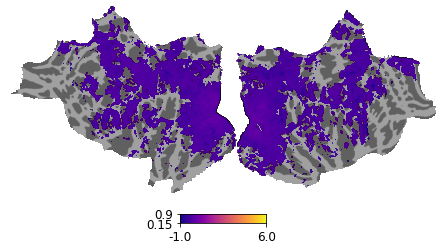

In [303]:
i=0.
for ims in psclist:
    
    i=i+1

    fig=cx.quickshow(ims, with_rois=False, with_curvature=True,fig=full_fig, with_colorbar=True)
    fig.savefig(os.path.join(dump_path,'fgif','gframe'+str(i)+'.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None)

In [239]:
import cortex
import matplotlib.pyplot as plt
import numpy as np

import cortex.polyutils


subject = '02'

surf=cortex.db.get_surf(subject, 'fiducial',merge=True)
surface = cortex.polyutils.Surface(surf[0], surf[1])

#left_surface = cortex.polyutils.Surface(left[0], left[1])
#right_surface = cortex.polyutils.Surface(right[0], right[1])


path = surface.geodesic_path(a=14449, b=105259)


In [240]:
path_data = np.zeros(numl*2)
for v in path:
    path_data[v] = 1

# And now plot these distances onto the cortical surface
path_verts = cortex.Vertex(path_data, subject, cmap="Blues_r")
cortex.quickshow(path_verts, with_colorbar=False,)
plt.show()

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


In [244]:
plt.plot(np.squeeze(eccarray)[path])

In [229]:
plt.plot(np.squeeze(iarray)[path])

In [243]:
np.squeeze(eccarray)[path]

array([0.39931563, 0.45281627, 0.4706069 , 0.44622278, 0.61274182,
       0.58298489, 0.77466892, 1.1018093 , 1.69977862, 1.96540602,
       2.27732924, 2.43657357, 2.50215307, 2.58696522, 2.50132602,
       2.51348956, 2.50758871, 2.49521119, 2.56367556, 2.77780266,
       2.98510571, 3.69740769, 3.95590928, 4.00523449, 4.62955111,
       4.70514574, 4.95126224, 5.0029292 , 5.52926117, 5.29574136,
       5.71948261, 5.58351394, 6.0253031 , 5.71233233, 5.5358075 ,
       5.8919324 , 6.10336855, 6.64436596, 6.68454244, 6.79414736,
       6.86031225, 7.00128758, 6.81145394, 7.06989186, 7.09988214,
       7.4395896 , 7.90053432, 7.75506761, 8.16214025, 8.54312247,
       9.84724167])

## Use pycortex functions for defining 'blobs' in V1

In [282]:
import matplotlib.pyplot as plt
import numpy as np

import cortex.polyutils


left, right = cortex.db.get_surf(subject, 'fiducial')
left_surface = cortex.polyutils.Surface(left[0], left[1])
right_surface = cortex.polyutils.Surface(right[0], right[1])

all_v1 = cortex.utils.get_roi_verts(subject, "V1")["V1"]

# Seperate by hemisphere.
numl = 163842
v1_verts = [all_v1[all_v1 < numl], all_v1[all_v1 >= numl] - numl]

# Now we have a list with the V1 vertices for each hemisphere. Lets just take a random one of these
chosenvert=v1_verts[0][3]

# We create a 4mm patch centred on this vertex
radius = 3

patch = left_surface.get_geodesic_patch(chosenvert, radius=radius)

In [283]:
# Create a sub-surface from this.
subsurface = left_surface.create_subsurface(vertex_mask=patch['vertex_mask'])

# Get the vertices that reside in this subsurface
subsurface_vertices=np.where(patch['vertex_mask']==True)

In [284]:
subsurface_vertices[0]

array([   348,   3923,  11599,  11601,  11602,  11603,  29588,  40565,
        40566,  40575,  42319,  42320,  42321,  42322,  42323,  57844,
        65047,  65048,  91169,  91170,  91171,  91195,  94607,  94608,
        94609,  94610,  94611,  94612,  94613, 120918, 130776, 130777,
       130778, 162650, 162651, 162652, 162653, 162654, 162679, 162680,
       162681, 162682, 162683, 162684])

Open the raw data up and get the data from this sub-surface

In [265]:
BIGDATAL=load('/Volumes/BAHAMUT/DUMP/BIGLHEM.pkl')

In [285]:
dsubset=BIGDATAL[:,subsurface_vertices[0]]

Get the distances from the centre of the patch. Use convert these into weights (the further the distance the less weight is applied).

In [269]:
data = subsurface.geodesic_distance([0])
data2 = [float(i)/max(data) for i in data]
from numpy import exp, linspace, random


def gaussian(x, amp, cen, wid):
    return amp * exp(-(x-cen)**2 / wid)

weights = gaussian(np.array(data2), 1, 0, 0.2)



plt.plot(data,weights,'*')

Now plot the subsurface and the data inside the subsurface.

In [270]:
from matplotlib import gridspec

fig = plt.figure(figsize=(17, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
ax0 = plt.subplot(gs[0])

dataset = cortex.Vertex(subsurface.lift_subsurface_data(weights), subject, cmap='viridis')
cortex.quickshow(dataset,fig=ax0)
plt.title('example V1 subsurface')
zoom_to_roi('02','V1','left')


ax1 = plt.subplot(gs[1])

ax1.plot(dsubset,alpha=0.1)
ax1.plot(np.squeeze(np.average(dsubset,axis=1,weights=weights)),linewidth=3)
plt.title('Weighted signal in sub-surface')

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


Text(0.5, 1.0, 'Weighted signal in sub-surface')

Export this subsurface to a gif

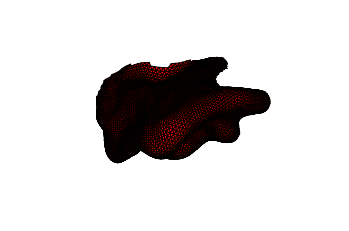

In [82]:
import tempfile
f, path = tempfile.mkstemp()
path = path + '.gif'
subsurface.plot_subsurface_rotating_gif(path=os.path.join(dump_path,'mysubsurf.gif'))

In [587]:
def my_patch(vertex,radius,hemsurf,hemdata,ROI,plot):
    patch = hemsurf.get_geodesic_patch(vertex, radius=radius)
    
    criterion1=patch['vertex_mask']
    criterion2=iL==ROI
    mymask=np.logical_and(criterion1 == True, criterion2 == True)

    subsurface = left_surface.create_subsurface(vertex_mask=mymask)
    subsurface_vertices=np.where(mymask==True)
    
    
    
    #subsurface = hemsurf.create_subsurface(vertex_mask=patch['vertex_mask'])
    #subsurface_vertices=np.where(patch['vertex_mask']==True)
    
    
    dsubset=hemdata[:,subsurface_vertices[0]]
    
    
    dists = subsurface.geodesic_distance([np.where(subsurface_vertices[0]==vertex)])
    dsubset=dsubset[:,0:int(dists.shape[0])]
    invdist = [float(i)/max(dists) for i in dists]
    weights = gaussian(np.array(invdist), 1, 0, 0.2)
    
    avdat=np.squeeze(np.average(dsubset,axis=1,weights=weights))
    dataset = cortex.Vertex(subsurface.lift_subsurface_data(weights), subject, cmap='viridis')
    if plot:

        fig = plt.figure(figsize=(17, 6)) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
        ax0 = plt.subplot(gs[0])

        
        cortex.quickshow(dataset,fig=ax0)
        plt.title('example V1 subsurface')
        zoom_to_roi('02','V1','left')

        ax1 = plt.subplot(gs[1])

        ax1.plot(dsubset,alpha=0.1)
        
        
        
        ax1.plot(avdat,linewidth=3)
        plt.title('Weighted signal in sub-surface')





    return patch, subsurface, subsurface_vertices, weights, dataset, avdat

In [ ]:
j=my_patch(34,1,left_surface,BIGDATAL,1,1)


In [688]:
cortex.webshow(j[4])

Started server on port 22893


<JS: window.viewer>

Stopping server


In [330]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy

In [358]:
def fitter(EV,DV):
    regressor = LinearRegression()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(EV, DV)
    r2=r_value**2
    fits=EV*slope
    return r2, fits 

In [559]:
myv2vert=444

In [743]:
sizes=list(np.linspace(3,25,2))

In [577]:
cond1=np.squeeze(R2arrayL)>15
cond2=iL == 1
mymask=np.logical_and(cond1 == True, cond2 ==True)

In [597]:
V1verts=list(np.where(mymask==True)[0])

In [744]:
import itertools
comblist=list(itertools.product(V1verts, sizes))

In [ ]:
patches = left_surface.get_geodesic_patches(seeds=V1verts,radius=3)

In [778]:
@delayed
@wrap_non_picklable_objects
def getpatch(comb,hemsurf,ROI):
    
    try: 
        vertex=comb[0]
        radius=comb[1]
    
        patch = hemsurf.get_geodesic_patch(vertex, radius=radius)
    
        criterion1=patch['vertex_mask']
        criterion2=iL==ROI
        mymask=np.logical_and(criterion1 == True, criterion2 == True)

        subsurface = left_surface.create_subsurface(vertex_mask=mymask)
        
        subsurface_vertices=np.where(mymask==True)
    
        
        dsubset=hemdata[:,subsurface_vertices[0]]
        
        
        
    except:
        
        pass
    return subsurface, dsubset

In [788]:
comb

(162700, 25.0)

In [790]:
from pathos.multiprocessing import ProcessingPool as Pool


x=[1,2,3,4,5]
y=[1,2,3,4,5]

p = Pool(4)



attempt=p.map(getpatch,comblist)

TypeError: can't pickle SuperLU objects

In [797]:
attempt=Parallel(n_jobs=5,verbose=9,backend='sequential')(delayed(getpatch)(comb,left_surface,1)  for comb in comblist)

[Parallel(n_jobs=5)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 4314 out of 4314 | elapsed:    0.2s finished


In [798]:
attempt

[(<joblib.externals.loky.cloudpickle_wrapper.CallableObjectWrapper at 0x4338c89e8>,
  ((34, 3.0), <cortex.polyutils.surface.Surface at 0x3d1b83d30>, 1),
  {}),
 (<joblib.externals.loky.cloudpickle_wrapper.CallableObjectWrapper at 0x4338c89e8>,
  ((34, 25.0), <cortex.polyutils.surface.Surface at 0x3d1b83d30>, 1),
  {}),
 (<joblib.externals.loky.cloudpickle_wrapper.CallableObjectWrapper at 0x4338c89e8>,
  ((86, 3.0), <cortex.polyutils.surface.Surface at 0x3d1b83d30>, 1),
  {}),
 (<joblib.externals.loky.cloudpickle_wrapper.CallableObjectWrapper at 0x4338c89e8>,
  ((86, 25.0), <cortex.polyutils.surface.Surface at 0x3d1b83d30>, 1),
  {}),
 (<joblib.externals.loky.cloudpickle_wrapper.CallableObjectWrapper at 0x4338c89e8>,
  ((346, 3.0), <cortex.polyutils.surface.Surface at 0x3d1b83d30>, 1),
  {}),
 (<joblib.externals.loky.cloudpickle_wrapper.CallableObjectWrapper at 0x4338c89e8>,
  ((346, 25.0), <cortex.polyutils.surface.Surface at 0x3d1b83d30>, 1),
  {}),
 (<joblib.externals.loky.cloudpickl

In [771]:
def patchtest(DV,comb,hemsurf,hemdata,ROI):
    
    try: 
        vertex=comb[0]
        radius=comb[1]
    
        patch = hemsurf.get_geodesic_patch(vertex, radius=radius)
    
        criterion1=patch['vertex_mask']
        criterion2=iL==ROI
        mymask=np.logical_and(criterion1 == True, criterion2 == True)

        subsurface = left_surface.create_subsurface(vertex_mask=mymask)
        subsurface_vertices=np.where(mymask==True)
    
        
        dsubset=hemdata[:,subsurface_vertices[0]]
    
    
        dists = subsurface.geodesic_distance([np.where(subsurface_vertices[0]==vertex)])
        dsubset=dsubset[:,0:int(dists.shape[0])]
        invdist = [float(i)/max(dists) for i in dists]
        weights = gaussian(np.array(invdist), 1, 0, 0.2)
        #dataset = cortex.Vertex(subsurface.lift_subsurface_data(weights), subject, cmap='viridis')
    
        avdat=np.squeeze(np.average(dsubset,axis=1,weights=weights))
        fits=fitter(avdat,DV)
    except: 
        avdat=DV
        fits=fitter(avdat,DV)
        #fits[0], fits[1]
    return avdat,fits[0], fits[1]  

In [610]:
from joblib import Parallel, delayed

In [718]:
v=patchtest(BIGDATAL[:,myv2vert],comblist[290],left_surface,BIGDATAL,1)

SyntaxError: unexpected EOF while parsing (<ipython-input-759-4cf5d5dd08b7>, line 2)

In [769]:

from joblib.externals.loky import set_loky_pickler

set_loky_pickler('dill')
from joblib import wrap_non_picklable_objects



In [799]:
attempt=Parallel(n_jobs=5,verbose=9,backend='sequential')(delayed(patchtest)(BIGDATAL[:,myv2vert],comb,left_surface,BIGDATAL,1)  for comb in comblist)

[Parallel(n_jobs=5)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   7 out of   7 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed:    3.5s remaining:    0.0s
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Traceback (most recent call last):


In [750]:
for comb in comblist:
    mylist.append(patchtest(BIGDATAL[:,myv2vert],comb,left_surface,BIGDATAL,1))

In [753]:
len(mylist)

4314

In [757]:
mylist[0][2]

array([-0.03065774, -0.10453728, -0.16129544, -0.18765635, -0.10909145,
        0.02493672,  0.12416707,  0.15156199,  0.11907104,  0.13188526,
        0.07965132,  0.09291797,  0.08080249,  0.10431181,  0.11439107,
        0.10555079,  0.02496195,  0.09094013,  0.03846045,  0.07609302,
        0.05602139,  0.10023629,  0.11824052,  0.17815908,  0.1704109 ,
        0.04096037, -0.16444158, -0.4119581 , -0.66869211, -0.69734322,
       -0.4625202 , -0.11492541,  0.07323004,  0.22174408,  0.21457265,
        0.10893355, -0.14276391, -0.50720047, -0.71928136, -0.9218054 ,
       -0.83565806, -0.48257695,  0.13252197,  0.49643117,  0.62320706,
        0.5242229 ,  0.49868914,  0.36934099,  0.3084695 ,  0.26719112,
        0.33336035,  0.23964484,  0.27780308,  0.30342678,  0.06830853,
       -0.12975953, -0.05509867, -0.13075062, -0.0068076 , -0.04371253,
       -0.01692545,  0.01610284, -0.03855824, -0.06909366, -0.02253718,
       -0.0722446 , -0.03880542,  0.01747463,  0.02696809, -0.01